<a href="https://colab.research.google.com/github/FloraQin0325/deep_learning_CW2/blob/master/460cw2_212(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework2: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

A PDF version of this notebook is also provided in case the figures do not render correctly.

**The deadline for submission is 19:00, Thu 14th February, 2019**

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [1]:
!pip install torch torchvision

    100% |████████████████████████████████| 2.0MB 14.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution and max pooling operation. 

### YOUR TASK

- implement the forward pass for Conv2D and MaxPool2D
- You can only fill in the parts which are specified as "YOUR CODE HERE"
- You are **NOT** allowed to use the torch.nn module and the conv2d/maxpooling functions in torch.nn.functional

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Conv2D(nn.Module):
    
    def __init__(self, inchannel, outchannel, kernel_size, stride, padding, bias = True):
        
        super(Conv2D, self).__init__()
        
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weights = nn.Parameter(torch.Tensor(outchannel, inchannel, 
                                                 kernel_size, kernel_size))
        self.weights.data.normal_(-0.1, 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.Tensor(outchannel, ))
            self.bias.data.normal_(-0.1, 0.1)
        else:
            self.bias = None
            
        
    def forward(self, x):
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        hout = ((x.shape[2] + 2 * self.padding - self.kernel_size)
                //self.stride)+1
        wout = ((x.shape[3] + 2 * self.padding - self.kernel_size)
                //self.stride)+1

        x_unf = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding
                         , stride=self.stride)
        if self.bias:
            out_unf = (x_unf.transpose(1, 2).matmul(self.weights.view(
                       self.weights.size(0), -1).t()).transpose(1, 2))+self.bias.view(-1, 1)
        else:
            out_unf = (x_unf.transpose(1, 2).matmul(self.weights.view(
                       self.weights.size(0), -1).t()).transpose(1, 2))
        output = out_unf.view(x.shape[0], self.outchannel, hout, wout)

        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
      
        

        return output
        

In [3]:
class MaxPool2D(nn.Module):
    
    def __init__(self, pooling_size):
        # assume pooling_size = kernel_size = stride
        
        super(MaxPool2D, self).__init__()
        
        self.pooling_size = pooling_size
        

    def forward(self, x):
     
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        batch_size = x.shape[0]

        inchannel = x.shape[1]

        x = F.unfold(x,kernel_size=self.pooling_size, stride=self.pooling_size)

        x = x.reshape(batch_size,inchannel,self.pooling_size*self.pooling_size,-1)

        x = x.max(dim=2)[0]

        shape = torch.rand(1)

        shape[0] = x.shape[0]*x.shape[1]*x.shape[2]
        
        shape =torch.sqrt(shape/(batch_size*inchannel))

        output = x.reshape(batch_size,inchannel,int(shape),int(shape))
      
        
        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
                
        
        return output
        

In [4]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2D(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2D(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2D(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


In [5]:
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2D(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2D(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

## Part 2 (40 points)

In this part, you will train the ResNet-18 defined in the previous part on the CIFAR-10 dataset. Code for loading the dataset, training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimiser

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

**YOUR ANSWER FOR 2.4 HERE**

A:In my opnion, Bayesian Optimisation is the best strategy for hyperparameter searching. Since the strategy will create a proxy model of the true model and train the hyperparameters on a more cheaper proxy model and return a really good result. And Training may be very cheaper compared with other strategies. Besides that, the training cycles is less.

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T


transform = T.ToTensor()
##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
transform_train = T.Compose([
    T.RandomCrop(32, padding = 4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])

transform_test = T.Compose([
    
    T.ToTensor(),
    T.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])
# load data

NUM_TRAIN = 49000
print_every = 100


data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transform_val)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transform_test)
loader_test = DataLoader(cifar10_test, batch_size=64)
##############################################################
#                       END OF YOUR CODE HERE                       #       
##############################################################

USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
    return acc
##############################################################
#                       END OF YOUR CODE                     #
##############################################################


def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()

In [8]:

# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

#setting up the range of all the hyperparameters. using Bayesian Optimisation

# readme 
I did data preprocessing using torchvision.transforms to do data standardization and data augmentation. Besides that, using bayesian optimisation of GPyOpt pakege to optimisate the learning_rate and weight_decay

In [9]:
!pip install GPy
!pip install GPyOpt

    100% |████████████████████████████████| 880kB 17.3MB/s 
    100% |████████████████████████████████| 71kB 24.0MB/s 
  Running setup.py bdist_wheel for GPy ... done
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Running setup.py bdist_wheel for paramz ... done
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built GPy paramz
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 61kB 4.9MB/s 
  Running setup.py bdist_wheel fo

In [10]:
import GPy
import GPyOpt

In [11]:
def objective(params):
  params = params.squeeze()
  model = ResNet18()
  optimizer = optim.Adam(model.parameters(),
                             lr = params[0], 
                             weight_decay = params[1]
                           )
  print("lr, weight_decay: ",params[0],params[1])
  train_part(model, optimizer, epochs = 10)
  acc = check_accuracy(loader_val, model)
  return acc
bounds = [{'name':'lr','type':'continuous','domain':(1e-5,4e-2)},
          {'name':'weight_decay','type':'continuous','domain':(1e-5,4e-2)}     
         ]
max_iter = 3
max_time = 100000000000
X = np.zeros((1,2))
X[0][0] = 0.001
X[0][1] = 0.0002
myProblem = GPyOpt.methods.BayesianOptimization(f = objective,X = X, domain = bounds, maximize = True)
myProblem.run_optimization(max_iter=max_iter, max_time=max_time)


lr, weight_decay:  0.001 0.0002
766
Epoch: 0, Iteration 0, loss = 2.3881

Epoch: 0, Iteration 100, loss = 2.2943

Epoch: 0, Iteration 200, loss = 2.3912

Epoch: 0, Iteration 300, loss = 2.1228

Epoch: 0, Iteration 400, loss = 2.0888

Epoch: 0, Iteration 500, loss = 1.6861

Epoch: 0, Iteration 600, loss = 2.0077

Epoch: 0, Iteration 700, loss = 1.8688

766
Epoch: 1, Iteration 0, loss = 1.4942

Epoch: 1, Iteration 100, loss = 1.7033

Epoch: 1, Iteration 200, loss = 1.4706

Epoch: 1, Iteration 300, loss = 1.3405

Epoch: 1, Iteration 400, loss = 1.3695

Epoch: 1, Iteration 500, loss = 1.4843

Epoch: 1, Iteration 600, loss = 1.3124

Epoch: 1, Iteration 700, loss = 0.9776

766
Epoch: 2, Iteration 0, loss = 1.0886

Epoch: 2, Iteration 100, loss = 1.3372

Epoch: 2, Iteration 200, loss = 0.9965

Epoch: 2, Iteration 300, loss = 1.2475

Epoch: 2, Iteration 400, loss = 0.8870

Epoch: 2, Iteration 500, loss = 1.0062

Epoch: 2, Iteration 600, loss = 0.8223

Epoch: 2, Iteration 700, loss = 0.7185

76

Best Hyperparameters:  [0.001  0.0002]
Best Accuracy:  -0.856


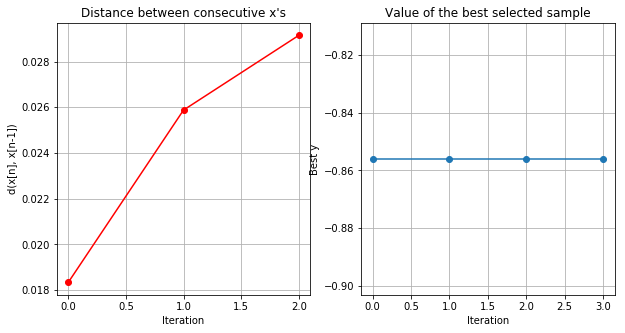

766
Epoch: 0, Iteration 0, loss = 2.7106

Epoch: 0, Iteration 100, loss = 2.2778

Epoch: 0, Iteration 200, loss = 2.2613

Epoch: 0, Iteration 300, loss = 2.0905

Epoch: 0, Iteration 400, loss = 2.0409

Epoch: 0, Iteration 500, loss = 2.0135

Epoch: 0, Iteration 600, loss = 1.8899

Epoch: 0, Iteration 700, loss = 1.8358

766
Epoch: 1, Iteration 0, loss = 1.6023

Epoch: 1, Iteration 100, loss = 1.6534

Epoch: 1, Iteration 200, loss = 1.4879

Epoch: 1, Iteration 300, loss = 1.5091

Epoch: 1, Iteration 400, loss = 1.5850

Epoch: 1, Iteration 500, loss = 1.1482

Epoch: 1, Iteration 600, loss = 1.2440

Epoch: 1, Iteration 700, loss = 1.1733

766
Epoch: 2, Iteration 0, loss = 1.2480

Epoch: 2, Iteration 100, loss = 1.1660

Epoch: 2, Iteration 200, loss = 1.3320

Epoch: 2, Iteration 300, loss = 1.0468

Epoch: 2, Iteration 400, loss = 0.9363

Epoch: 2, Iteration 500, loss = 0.8560

Epoch: 2, Iteration 600, loss = 0.8993

Epoch: 2, Iteration 700, loss = 1.0031

766
Epoch: 3, Iteration 0, loss = 

In [14]:
print("Best Hyperparameters: ", myProblem.x_opt)
print("Best Accuracy: ",myProblem.fx_opt)
myProblem.plot_convergence()
##############################################################
#                       END OF YOUR CODE HERE                       #       
##############################################################


# define and train the network

model = ResNet18()
bestParams = myProblem.x_opt
optimizer = optim.Adam(model.parameters(), lr = bestParams[0], weight_decay = bestParams[1])

train_part(model, optimizer, epochs = 10)


# report test set accuracy

check_accuracy(loader_test, model)

torch.save(model.state_dict(), 'model.pt')

In [ ]:
## Part 3 (20 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

1: the number of feature maps increases from low-level layers to high-level layers. And the low-level feature maps tends to be simpler like edge detection, etc, while the high level feature maps are more complex and begin to demonstrate the real features.

2: I think the performance of my convolutional neural network is not sufficiently good. First of all, the accuracy is not high enough. I think adding number of epochs or number of bayesian optimisation max iterations may help to improve the performance. Besides that, maybe a different approach of dataset preprocessing e.g. kai_ming would improve the performance

3: Confusion Matrix, Graphs of error rate

<Figure size 432x288 with 0 Axes>

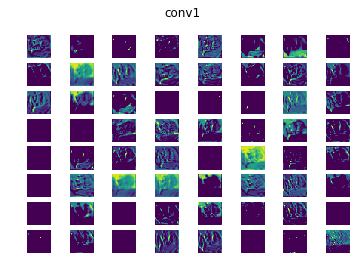

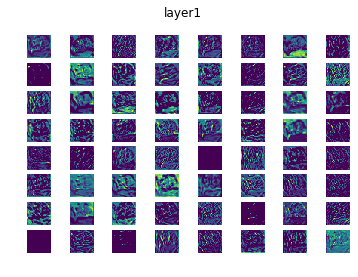

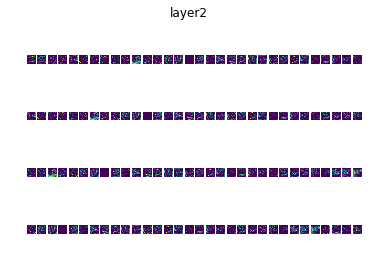

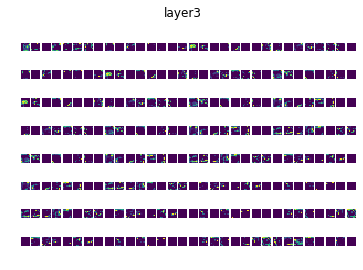

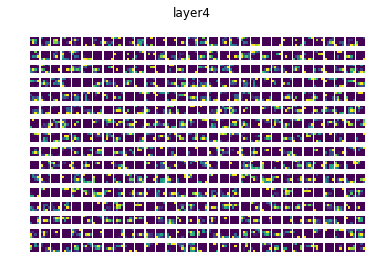

In [23]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')

**=============== END OF CW2 ===============**